## Setup

In [1]:
import MEArec as mr
import numpy as np
import scipy.optimize
import os
import sys
import re
import ast
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import pickle
import time
from collections import defaultdict
from joblib import Parallel, delayed

import spikeinterface as si
import spikeinterface.core as sc
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
import spikeinterface.comparison as scomp
import spikeinterface.curation as scu

sys.path.append('src')
from src.util_eval import *
from src.util_loc import *

In [2]:
# Overall parameters
mearec_seeds = [42, 43, 44, 45, 46]
dead_indices_seeds = [42, 43, 44, 45, 46]
run_id = f'20260210'
sorter_name = 'mountainsort4'
days = ['D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9',
        'D10','D11','D12','D13','D14','D15','D16','D17','D18','D19',
        'D20','D21','D22','D23','D24']
methods = ['center_of_mass', 'monopolar_triangulation', 'grid_convolution']
stable_days = 1
dead_electrodes_per_day = 15
gt_toggle = 0 # if 0, use ground truth data as experimental data
correct_radius = 30 # microns

# MEArec parameters
mearec_probe = 'Neuropixels-384'
num_channels = 384
recgen_duration = 60
mearec_noise_level = 10
output_mearec = f'output/{run_id}'

## Figure Charts - Across Seeds

In [3]:
def get_run_params(mearec_seed, dead_indices_seed):

    seed_folder = f'{output_mearec}_{mearec_seed}/seed_{dead_indices_seed}'
    
    # Recording data
    recording_mearec = se.MEArecRecordingExtractor(f'{seed_folder}/D0/recording.h5')
    probe = recording_mearec.get_probe()

    # Waveform extractor data
    wes_gt = []
    for day_i, day in enumerate(days):
        wes_gt.append(si.load_waveforms(f'{output_mearec}_{mearec_seed}/seed_42/{day}/waveforms_gt', with_recording=False))

    # Dead indices
    with open(f'{seed_folder}/dead_indices.pkl', 'rb') as f:
        dead_indices = pickle.load(f)

    # Load tempgen and recgen
    tempgen = mr.load_templates(f'{seed_folder}/templates.h5')
    recgen = mr.load_recordings(f'{seed_folder}/D0/recording.h5')

    # Load templates
    with open(f'{seed_folder}/loc_est_units/loc_est_units.pkl', 'rb') as f:
        loc_est_units = pickle.load(f)
    with open(f'{seed_folder}/loc_est_units/time_units.pkl', 'rb') as f:
        time_units = pickle.load(f)

    # Load spikes
    with open(f'{seed_folder}/loc_est_spikes/loc_est_spikes.pkl', 'rb') as f:
        loc_est_spikes = pickle.load(f)
    with open(f'{seed_folder}/loc_est_spikes/time_spikes.pkl', 'rb') as f:
        time_spikes = pickle.load(f)
    
    electrode_loc = recording_mearec.get_channel_locations()
    unit_loc_true = recgen.template_locations
    
    return wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true

def get_run_params_grid(mearec_seed, dead_indices_seed):

    seed_folder = f'{output_mearec}_{mearec_seed}/seed_{dead_indices_seed}'
    
    # Recording data
    recording_mearec = se.MEArecRecordingExtractor(f'{seed_folder}/D0/recording.h5')
    probe = recording_mearec.get_probe()

    # Waveform extractor data
    wes_gt = []
    for day_i, day in enumerate(days):
        wes_gt.append(si.load_waveforms(f'{output_mearec}_{mearec_seed}/seed_42/{day}/waveforms_gt', with_recording=False))

    # Dead indices
    with open(f'{seed_folder}/dead_indices.pkl', 'rb') as f:
        dead_indices = pickle.load(f)

    # Load tempgen and recgen
    tempgen = mr.load_templates(f'{seed_folder}/templates.h5')
    recgen = mr.load_recordings(f'{seed_folder}/D0/recording.h5')

    # Load templates
    with open(f'{seed_folder}/loc_est_units/loc_est_units.pkl', 'rb') as f:
        loc_est_units = pickle.load(f)
    with open(f'{seed_folder}/loc_est_units/loc_est_grid_units.pkl', 'rb') as f:
        loc_est_grid_units = pickle.load(f)

    # Load spikes
    with open(f'{seed_folder}/loc_est_spikes/loc_est_spikes.pkl', 'rb') as f:
        loc_est_spikes = pickle.load(f)
    with open(f'{seed_folder}/loc_est_spikes/loc_est_grid_spikes.pkl', 'rb') as f:
        loc_est_grid_spikes = pickle.load(f)
    
    electrode_loc = recording_mearec.get_channel_locations()
    unit_loc_true = recgen.template_locations
    
    return wes_gt, dead_indices, tempgen, recgen, loc_est_units, loc_est_grid_units, loc_est_spikes, loc_est_grid_spikes, electrode_loc, unit_loc_true

In [4]:
fig_days = ['D0', 'D2', 'D4', 'D6', 'D8', 'D10', 'D12', 'D14', 'D16', 'D18', 'D20', 'D22', 'D24']

fig_days_label = []
for day_i in range(len(fig_days)):
    fig_days_label.append(dead_electrodes_per_day*days.index(fig_days[day_i])/num_channels)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
fig_method_label = ['COM', 'MT', 'GC']
os.makedirs(f'{output_mearec}', exist_ok=True)

Method: center_of_mass, Losses: [0.76, 0.8, 0.78, 0.82, 0.68]
Method: monopolar_triangulation, Losses: [0.948, 0.98, 0.98, 0.96, 0.98]
Method: grid_convolution, Losses: [0.936, 1.0, 0.96, 0.94, 0.92]


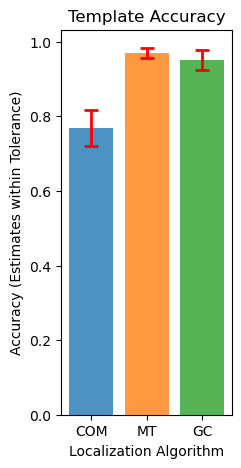

In [5]:
"""Figure 2: Template Accuracy with No Dead Electrodes"""

loss_mean = []
loss_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))

for method_i, method in enumerate(methods):
    
    loss_method = []
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        n_right = 0
        n_wrong = 0
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]
            
            unit_loc_est = loc_est_units[method]
            for unit_idx, unit_id in enumerate(we.unit_ids):
                if np.linalg.norm(unit_loc_est[0][unit_idx, :2] - recgen.template_locations[unit_idx, 1:]) < correct_radius:
                    n_right += 1
                else:
                    n_wrong += 1
            
        loss_method.append(n_right / (n_right + n_wrong))

    loss_mean.append(np.mean(loss_method))
    loss_std.append(np.std(loss_method))
    print(f'Method: {method}, Losses: {loss_method}') # print loss data

    
# Create plot
error_kw = {'ecolor': 'red', 'capsize': 5, 'capthick': 2, 'elinewidth': 2}
ax.bar(fig_method_label, loss_mean, yerr=loss_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Template Accuracy')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')

fig.savefig(f'{output_mearec}/2A_1.svg', format='svg', bbox_inches='tight')

center_of_mass
Method: center_of_mass, Losses: [0.6892341842397336, 0.7956189693030417, 0.7993098628461606, 0.7926826099384154, 0.7026842312095273]
monopolar_triangulation
Method: monopolar_triangulation, Losses: [0.9474088619482626, 0.9804743200566874, 0.9694417751375907, 0.9591774865527367, 0.9517829377893964]
grid_convolution
Method: grid_convolution, Losses: [0.9588406044565867, 0.9928965716335261, 0.9613697912116712, 0.9434132229257434, 0.9234285030840467]


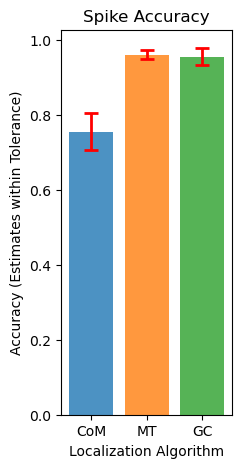

In [6]:
"""Figure 2: Spike Accuracy with No Dead Electrodes"""

loss_mean = []
loss_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    

for method in methods:
    print(method)
    
    loss_method = []
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        n_right = 0
        n_wrong = 0
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]
                        
            unit_loc_est = loc_est_spikes[method][days[we_i]]
            
            # Calculate loss
            for unit_idx, unit_id in enumerate(we.unit_ids):
                unit_n_right, unit_n_wrong = get_loss_acc_spikes_2(recgen.template_locations[unit_idx], unit_loc_est[0][unit_id], correct_radius)
                n_right += unit_n_right
                n_wrong += unit_n_wrong

        loss_method.append(n_right / (n_right + n_wrong))

    loss_mean.append(np.mean(loss_method))
    loss_std.append(np.std(loss_method))    
    print(f'Method: {method}, Losses: {loss_method}') # print loss data

error_kw = {'ecolor': 'red', 'capsize': 5, 'capthick': 2, 'elinewidth': 2}
ax.bar(['CoM','MT','GC'], loss_mean, yerr=loss_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Spike Accuracy')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')
fig.savefig(f'{output_mearec}/2B_1.svg', format='svg', bbox_inches='tight')

center_of_mass
Method: center_of_mass, Losses: [0.3704427  0.37558773 0.37847214 0.38409142 0.37688988]
monopolar_triangulation
Method: monopolar_triangulation, Losses: [27.19013962 27.87210678 28.46576454 28.7263596  27.78132885]
grid_convolution
Method: grid_convolution, Losses: [18.66677917 18.42272198 18.48183426 18.37904091 18.36060638]


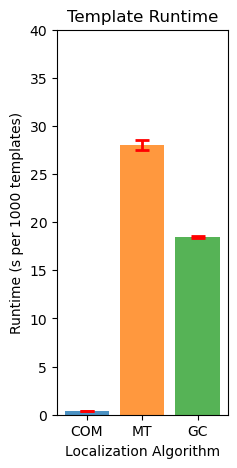

In [7]:
"""Figure 2: Template Runtime with No Dead Electrodes"""

time_mean = []
time_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))

for method_i, method in enumerate(methods):
    print(method)
    
    time_method = np.zeros(len(mearec_seeds))
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        n_templates = 0
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            time_method[mearec_seed_i] += time_units[method]
            n_templates += loc_est_units[method][0].shape[0] * len(loc_est_units[method])
        time_method[mearec_seed_i] = 1000 * time_method[mearec_seed_i] / n_templates
    
    time_mean.append(np.mean(time_method))
    time_std.append(np.std(time_method))
    print(f'Method: {method}, Losses: {time_method}') # print loss data

error_kw = {'ecolor': 'red', 'capsize': 5, 'capthick': 2, 'elinewidth': 2}
ax.bar(fig_method_label, time_mean, yerr=time_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Template Runtime')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Runtime (s per 1000 templates)')
ax.set_ylim([0, 40])
fig.savefig(f'{output_mearec}/2A_2.svg', format='svg', bbox_inches='tight')

center_of_mass
Method: center_of_mass, Losses: [0.12832458 0.13098431 0.15845586 0.15931376 0.1325621 ]
monopolar_triangulation
Method: monopolar_triangulation, Losses: [2.4332882  2.38658033 2.86642419 4.13877384 2.30723631]
grid_convolution
Method: grid_convolution, Losses: [0.36396061 0.38289058 0.38832215 0.37640081 0.35143242]


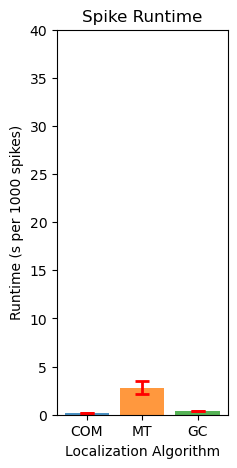

In [8]:
"""Figure 2: Spike Runtime with No Dead Electrodes"""

time_mean = []
time_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))
for method_i, method in enumerate(methods):
    print(method)
    
    time_method = np.zeros(len(mearec_seeds))
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        n_spikes = 0
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            time_method[mearec_seed_i] += time_spikes[method][days[0]]
            for value in loc_est_spikes[method][days[0]][0].values():
                n_spikes += value.shape[0]
                
        time_method[mearec_seed_i] = 1000 * time_method[mearec_seed_i] / n_spikes
    
    time_mean.append(np.mean(time_method))
    time_std.append(np.std(time_method))
    print(f'Method: {method}, Losses: {time_method}') # print loss data

error_kw = {'ecolor': 'red', 'capsize': 5, 'capthick': 2, 'elinewidth': 2}
ax.bar(fig_method_label, time_mean, yerr=time_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Spike Runtime')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Runtime (s per 1000 spikes)')
ax.set_ylim([0, 40])
fig.savefig(f'{output_mearec}/2B_2.svg', format='svg', bbox_inches='tight')

center_of_mass
Method: center_of_mass, Losses: [22.894378477626077, 19.833213628493755, 14.314993662575711, 16.928998826200356, 21.61482543438035]
monopolar_triangulation
Method: monopolar_triangulation, Losses: [9.694596058402954, 9.206518342588966, 8.09430984260663, 9.527540293370555, 7.55022512009575]
grid_convolution
Method: grid_convolution, Losses: [13.061471409014086, 10.255798031575239, 8.149425718911237, 8.058212956872413, 11.633945549890859]


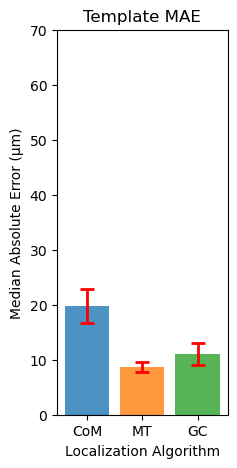

In [9]:
"""Figure 2: Template MAE with No Dead Electrodes"""

loss_median = []
loss_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))
for method_i, method in enumerate(methods):
    print(method)
    
    loss_method = []
    all_errors_2 = []
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        all_errors = []
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]

            unit_loc_est = loc_est_units[method]
            
            # Calculate absolute errors for each template
            diff = unit_loc_true[:, 1:] - unit_loc_est[we_i][:, :2]
            template_errors = np.linalg.norm(diff, axis=1)
            all_errors.extend(template_errors)
            all_errors_2.extend(template_errors)
        
        loss_method.append(np.median(all_errors))

    loss_median.append(np.median(all_errors_2))
    loss_std.append(np.std(loss_method))
    print(f'Method: {method}, Losses: {loss_method}') # print loss data

error_kw = {'ecolor': 'red', 'capsize': 5, 'capthick': 2, 'elinewidth': 2}
ax.bar(['CoM','MT','GC'], loss_median, yerr=loss_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Template MAE')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Median Absolute Error (μm)')
ax.set_ylim([0, 70])
fig.savefig(f'{output_mearec}/2A_3.svg', format='svg', bbox_inches='tight')

center_of_mass
Method: center_of_mass, Losses: [23.742887987751683, 21.880784664556163, 14.54603706783945, 18.411839483499474, 20.79066197251374]
monopolar_triangulation
Method: monopolar_triangulation, Losses: [10.23157484472158, 9.80050384851718, 8.013425802332671, 8.16883685405141, 8.381141226789177]
grid_convolution
Method: grid_convolution, Losses: [13.28601826035306, 11.216081156570494, 9.834401392417227, 9.51838794001307, 10.28630518520637]


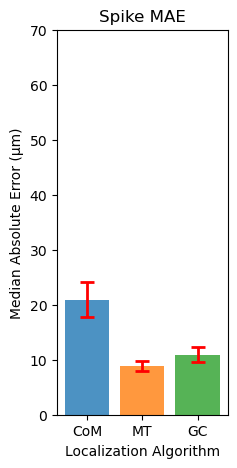

In [10]:
"""Figure 2: Spike MAE with No Dead Electrodes"""

loss_median = []
loss_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    

for method in methods:
    print(method)
    
    loss_method = []
    all_errors_2 = []
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):
    
        all_errors = []
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):        
            
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]
            
            unit_loc_est = loc_est_spikes[method][days[we_i]]

            # Calculate absolute errors for each spike
            for unit_idx, unit_id in enumerate(we.unit_ids):                
                spike_locations = unit_loc_est[0][unit_id]
                for spike_loc_est in spike_locations:
                    spike_loc_est = np.array(spike_loc_est.tolist())[:2]
                    diff = unit_loc_true[unit_idx, 1:] - spike_loc_est
                    spike_error = np.sqrt(np.sum(diff**2))
                    all_errors.append(spike_error)
                    all_errors_2.append(spike_error)
        
        loss_method.append(np.median(all_errors) if len(all_errors) > 0 else 0)

    loss_median.append(np.median(all_errors_2))
    loss_std.append(np.std(loss_method))
    print(f'Method: {method}, Losses: {loss_method}') # print loss data

error_kw = {'ecolor': 'red', 'capsize': 5, 'capthick': 2, 'elinewidth': 2}
ax.bar(['CoM','MT','GC'], loss_median, yerr=loss_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Spike MAE')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Median Absolute Error (μm)')
ax.set_ylim([0, 70])
fig.savefig(f'{output_mearec}/2B_3.svg', format='svg', bbox_inches='tight')

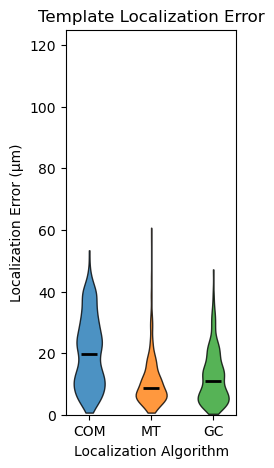

In [11]:
"""Figure 2: Template Error Violin Plot with No Dead Electrodes"""

loss = []
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    
for method_i, method in enumerate(methods):

    error = [] # Hold all individual error
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]

            unit_loc_est = loc_est_units[method]
            diff = unit_loc_true[:, 1:] - unit_loc_est[we_i][:, :2]
            error.extend(np.sqrt(np.sum(diff**2, axis=1)))

    loss.append(error)

# Create violin plot
parts = ax.violinplot(loss, showmeans=False, showmedians=True, showextrema=False)

# Customize violin plot
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)

# Add median line
parts['cmedians'].set_color('black')
parts['cmedians'].set_linewidth(2)

# Set the x-ticks to correspond to each method
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['COM', 'MT', 'GC'])

ax.title.set_text('Template Localization Error')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Localization Error (μm)')
ax.set_ylim([0, 125])
fig.savefig(f'{output_mearec}/2A_4.svg', format='svg', bbox_inches='tight')

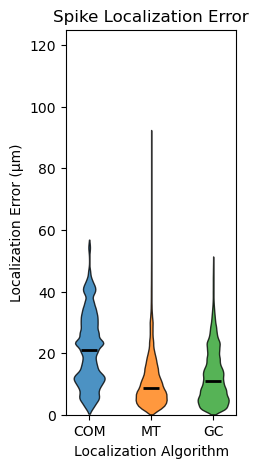

In [12]:
"""Figure 2: Spike Error Violin Plot with No Dead Electrodes"""

loss = []
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    
for method in methods:

    day_err = []
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]

            unit_loc_est = loc_est_spikes[method][days[we_i]]
            
            # Calculate loss
            for unit_idx, unit_id in enumerate(we.unit_ids):                
                unit_err = get_loss_RMSE_spikes_ind(unit_loc_true[unit_idx], unit_loc_est[0][unit_id])
                day_err.extend(unit_err)
            
    day_err.sort()
    day_err = day_err[100:-100] # Exclude lowest and highest 100 errors for violin plot visualization (out of 587737 error values, represents 0.034%)
    loss.append(day_err)

# Create violin plot
parts = ax.violinplot(loss, showmeans=False, showmedians=True, showextrema=False)

# Customize violin plot
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)

# Add median line
parts['cmedians'].set_color('black')
parts['cmedians'].set_linewidth(2)

# Set x-ticks to correspond to each method
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['COM', 'MT', 'GC'])

ax.title.set_text('Spike Localization Error')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Localization Error (μm)')
ax.set_ylim([0, 125])

fig.savefig(f'{output_mearec}/2B_4.svg', format='svg', bbox_inches='tight')

D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24
D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24
D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24


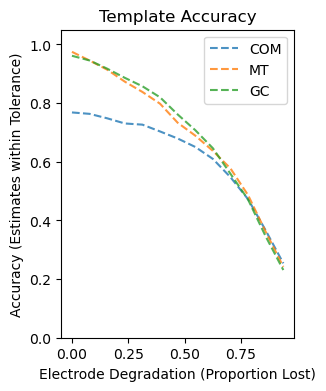

In [13]:
"""Figure 3A: Template Accuracy v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
for method_i, method in enumerate(methods):

    loss_mean = []
    for day_i, day in enumerate(days):
        print(day)
        
        if day in fig_days:

            loss_day = []
            for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

                n_right = 0
                n_wrong = 0
                for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                    
                    wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
                    we_i = day_i
                    we = wes_gt[we_i]
                    
                    unit_loc_est = loc_est_units[method]
                    for unit_idx, unit_id in enumerate(we.unit_ids):
                        if np.linalg.norm(unit_loc_est[we_i][unit_idx, :2] - recgen.template_locations[unit_idx, 1:]) < correct_radius:
                            n_right += 1
                        else:
                            n_wrong += 1
                    
                loss_day.append(n_right / (n_right + n_wrong))

            loss_mean.append(np.mean(loss_day))

    # Create plot
    loss_mean = np.array(loss_mean)
    method_jit = method_i * 0.005
    ax.plot(fig_days_label, loss_mean + method_jit, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Template Accuracy')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')
ax.set_ylim([0, 1.05])
ax.legend()

fig.savefig(f'{output_mearec}/3A_1.svg', format='svg', bbox_inches='tight')

D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24
D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24
D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24


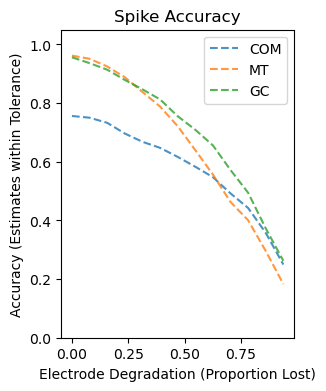

In [14]:
"""Figure 3A: Spike Accuracy v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
for method_i, method in enumerate(methods):

    loss_mean = []
    for day_i, day in enumerate(days):

        print(day)
        if day in fig_days:

            loss_day = []
            for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):
            
                n_right = 0
                n_wrong = 0
                for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                    
                    wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
                    we_i = day_i
                    we = wes_gt[we_i]

                    unit_loc_est = loc_est_spikes[method][days[we_i]]
                    
                    # Calculate loss
                    for unit_idx, unit_id in enumerate(we.unit_ids):
                        unit_n_right, unit_n_wrong = get_loss_acc_spikes_2(recgen.template_locations[unit_idx], unit_loc_est[0][unit_id], correct_radius)
                        n_right += unit_n_right
                        n_wrong += unit_n_wrong

                loss_day.append(n_right / (n_right + n_wrong))

            loss_mean.append(np.mean(loss_day))

    # Create plot
    ax.plot(fig_days_label, loss_mean, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Spike Accuracy')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')
ax.set_ylim([0, 1.05])
ax.legend()

fig.savefig(f'{output_mearec}/3B_1.svg', format='svg', bbox_inches='tight')

D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24
D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24
D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24


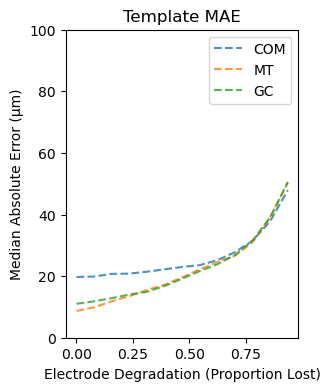

In [15]:
"""Figure 3A: Template MAE v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
for method_i, method in enumerate(methods):

    loss_median = []
    for day_i, day in enumerate(days):

        print(day)
        if day in fig_days:

            all_errors = []
            for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

                for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                    wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
                    we_i = day_i
                    we = wes_gt[we_i]
                    
                    unit_loc_est = loc_est_units[method]
                    # Calculate absolute errors for each template
                    diff = unit_loc_true[:, 1:] - unit_loc_est[we_i][:, :2]
                    template_errors = np.linalg.norm(diff, axis=1)
                    all_errors.extend(template_errors)
            
            loss_median.append(np.median(all_errors))

    # Create plot
    loss_median = np.array(loss_median)
    ax.plot(fig_days_label, loss_median, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Template MAE')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Median Absolute Error (μm)')
ax.set_ylim([0, 100])
ax.legend()

fig.savefig(f'{output_mearec}/3A_2.svg', format='svg', bbox_inches='tight')

D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24
D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24
D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24


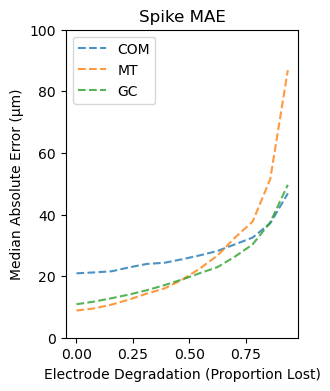

In [16]:
"""Figure 3B: Spike MAE v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
for method_i, method in enumerate(methods):

    loss_median = []
    for day_i, day in enumerate(days):

        print(day)
        if day in fig_days:

            all_errors = []
            for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

                for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                    
                    wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
                    we_i = day_i
                    we = wes_gt[we_i]
                
                    unit_loc_est = loc_est_spikes[method][day]
                    
                    # Calculate absolute errors for each spike
                    for unit_idx, unit_id in enumerate(we.unit_ids):                
                        spike_locations = unit_loc_est[0][unit_id]
                        for spike_loc_est in spike_locations:
                            spike_loc_est = np.array(spike_loc_est.tolist())[:2]
                            diff = unit_loc_true[unit_idx, 1:] - spike_loc_est
                            spike_error = np.sqrt(np.sum(diff**2))
                            all_errors.append(spike_error)
            
            loss_median.append(np.median(all_errors) if len(all_errors) > 0 else 0)

    # Create plot
    ax.plot(fig_days_label, loss_median, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Spike MAE')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Median Absolute Error (μm)')
ax.set_ylim([0, 100])
ax.legend()

fig.savefig(f'{output_mearec}/3B_2.svg', format='svg', bbox_inches='tight')

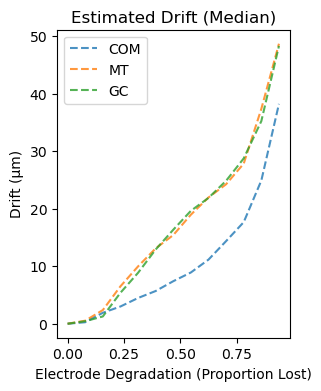

In [17]:
"""Figure 3A: Template Drift (Median)"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
estimated_drift = {}

for method in methods:
    estimated_drift[method] = []
    
    for day_i, day in enumerate(days):
        if day in fig_days:
            
            drift_day = []
            for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):
                
                for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                    wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
                    
                    loc_est_unit_0 = loc_est_units[method][0]
                    loc_est_unit = loc_est_units[method][day_i]
                    
                    # Calculate drift for each unit individually
                    unit_drifts = np.linalg.norm(loc_est_unit[:, :2] - loc_est_unit_0[:, :2], axis=1)
                    drift_day.extend(unit_drifts)
            
            estimated_drift[method].append(np.median(drift_day) if len(drift_day) > 0 else 0)
                        
for method_i, method in enumerate(methods):
    ax.plot(fig_days_label, estimated_drift[method], linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text('Estimated Drift (Median)')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Drift (μm)')
ax.legend()
fig.savefig(f'{output_mearec}/3A_3.svg', format='svg', bbox_inches='tight')

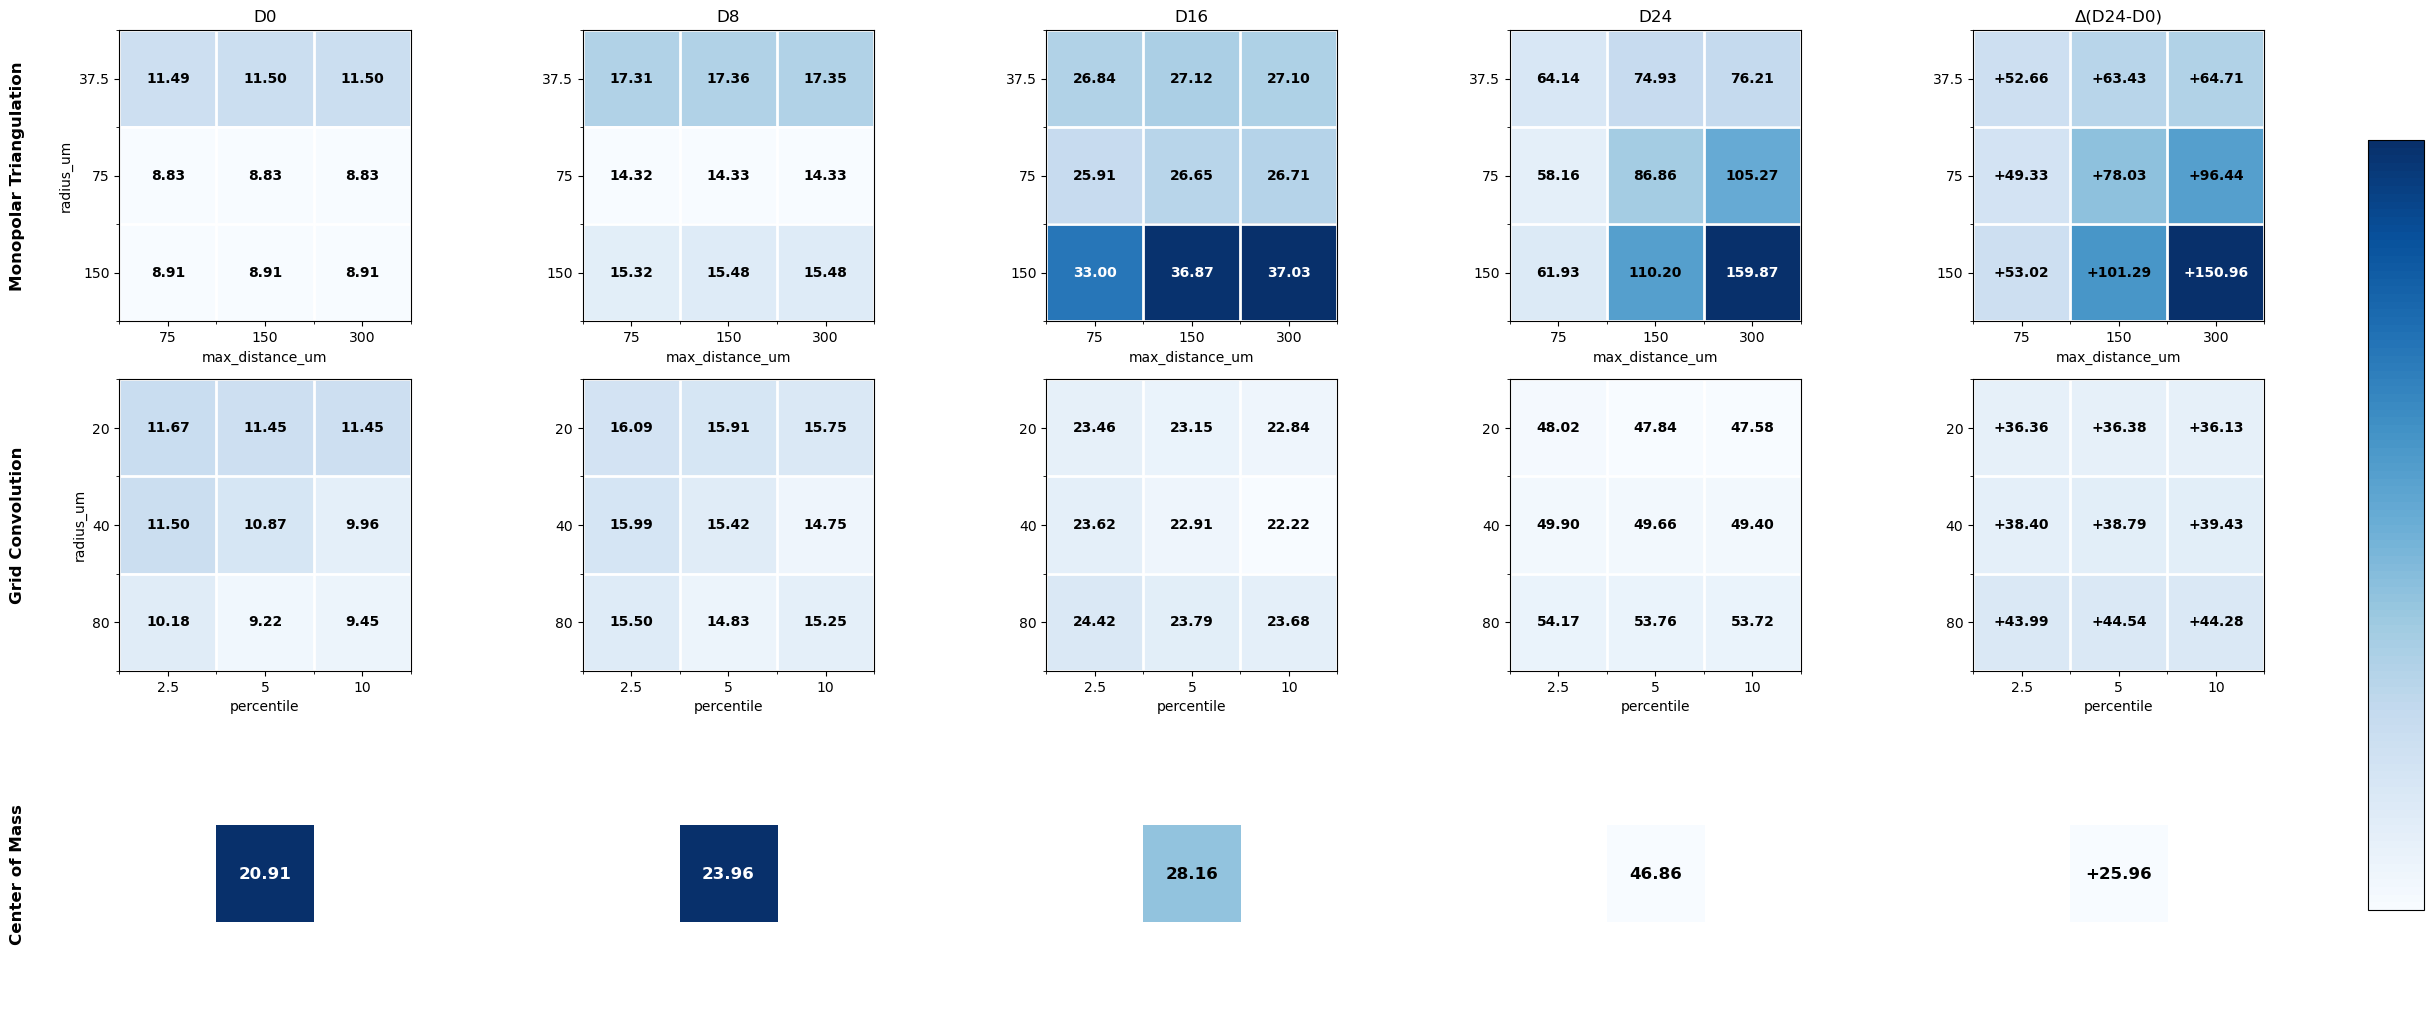

In [5]:
"""Figure 5: Parameter Search MEArec"""

# Grid search parameters
mt_param_1 = [37.5, 75, 150] # radius_um
mt_param_2 = [75, 150, 300] # max_distance_um

gc_param_1 = [20, 40, 80] # radius_um
gc_param_2 = [2.5, 5, 10] # percentile        

# Initialize grid for median spike localization errors
grid_errors_spikes = {}

for param_1_i, param_1 in enumerate(mt_param_1):
    grid_errors_spikes[param_1_i] = {}
    
    for param_2_i, param_2 in enumerate(mt_param_2):
        grid_errors_spikes[param_1_i][param_2_i] = {}
        grid_errors_spikes[param_1_i][param_2_i]['monopolar_triangulation'] = {}
        grid_errors_spikes[param_1_i][param_2_i]['grid_convolution'] = {}
        grid_errors_spikes[param_1_i][param_2_i]['center_of_mass'] = {}
        
        for day_i, day in enumerate(['D0', 'D8', 'D16', 'D24']):
            grid_errors_spikes[param_1_i][param_2_i]['monopolar_triangulation'][day] = []
            grid_errors_spikes[param_1_i][param_2_i]['grid_convolution'][day] = []
            grid_errors_spikes[param_1_i][param_2_i]['center_of_mass'][day] = []

# Calculate median spike localization errors.
for mearec_seed in mearec_seeds:
        
    for dead_indices_seed in dead_indices_seeds:

        wes_gt, dead_indices, tempgen, recgen, loc_est_units, loc_est_grid_units, loc_est_spikes, loc_est_grid_spikes, electrode_loc, unit_loc_true = get_run_params_grid(mearec_seed, dead_indices_seed)
        
        # loc_est_grid_spikes[param_1_i][param_2_i]['monopolar_triangulation']['D0'][0]['#0']
        # Append spike errors across grid for MT
        for param_1_i, param_1 in enumerate(mt_param_1):            
            for param_2_i, param_2 in enumerate(mt_param_2):

                for day_i, day in enumerate(['D0', 'D8', 'D16', 'D24']):

                    we_i = days.index(day) # Waveform index for this day.
                    we = wes_gt[we_i] # Waveform for this day.
                    
                    unit_loc_est = loc_est_grid_spikes[param_1_i][param_2_i]['monopolar_triangulation']
                    
                    # Calculate absolute errors for each spike
                    for unit_idx, unit_id in enumerate(we.unit_ids):                
                        spike_locations = unit_loc_est[day][0][unit_id]
                        for spike_loc_est in spike_locations:
                            spike_loc_est = np.array(spike_loc_est.tolist())[:2]
                            diff = unit_loc_true[unit_idx, 1:] - spike_loc_est
                            spike_error = np.sqrt(np.sum(diff**2))
                            grid_errors_spikes[param_1_i][param_2_i]['monopolar_triangulation'][day].append(spike_error)
        
        # Append spike errors across grid for GC
        for param_1_i, param_1 in enumerate(gc_param_1):            
            for param_2_i, param_2 in enumerate(gc_param_2):

                for day_i, day in enumerate(['D0', 'D8', 'D16', 'D24']):
                    
                    we_i = days.index(day)
                    we = wes_gt[we_i]
                    
                    unit_loc_est = loc_est_grid_spikes[param_1_i][param_2_i]['grid_convolution']
                    
                    # Calculate absolute errors for each spike
                    for unit_idx, unit_id in enumerate(we.unit_ids):                
                        spike_locations = unit_loc_est[day][0][unit_id]
                        for spike_loc_est in spike_locations:
                            spike_loc_est = np.array(spike_loc_est.tolist())[:2]
                            diff = unit_loc_true[unit_idx, 1:] - spike_loc_est
                            spike_error = np.sqrt(np.sum(diff**2))
                            grid_errors_spikes[param_1_i][param_2_i]['grid_convolution'][day].append(spike_error)

        # loc_est_spikes['center_of_mass']['D0'][0]['#0']
        # Append spike errors for COM (no parameter search)
        for day_i, day in enumerate(['D0', 'D8', 'D16', 'D24']):
            
            # Map day to index in days array
            we_i = days.index(day)
            we = wes_gt[we_i]
            
            unit_loc_est = loc_est_spikes['center_of_mass']
            
            # Calculate absolute errors for each spike
            for unit_idx, unit_id in enumerate(we.unit_ids):                
                spike_locations = unit_loc_est[day][0][unit_id]
                for spike_loc_est in spike_locations:
                    spike_loc_est = np.array(spike_loc_est.tolist())[:2]
                    diff = unit_loc_true[unit_idx, 1:] - spike_loc_est
                    spike_error = np.sqrt(np.sum(diff**2))
                    grid_errors_spikes[0][0]['center_of_mass'][day].append(spike_error)

# Calculate median errors
grid_median_errors_spikes = {}

for param_1_i in range(len(mt_param_1)):
    grid_median_errors_spikes[param_1_i] = {}
    
    for param_2_i in range(len(mt_param_2)):
        grid_median_errors_spikes[param_1_i][param_2_i] = {}
        grid_median_errors_spikes[param_1_i][param_2_i]['monopolar_triangulation'] = {}
        grid_median_errors_spikes[param_1_i][param_2_i]['grid_convolution'] = {}
        grid_median_errors_spikes[param_1_i][param_2_i]['center_of_mass'] = {}
        
        for day in ['D0', 'D8', 'D16', 'D24']:
            # Monopolar triangulation median error
            errors_mt = grid_errors_spikes[param_1_i][param_2_i]['monopolar_triangulation'][day]
            grid_median_errors_spikes[param_1_i][param_2_i]['monopolar_triangulation'][day] = np.nanmedian(errors_mt)
            
            # Grid convolution median error
            errors_gc = grid_errors_spikes[param_1_i][param_2_i]['grid_convolution'][day]
            grid_median_errors_spikes[param_1_i][param_2_i]['grid_convolution'][day] = np.nanmedian(errors_gc)
            
            # Center of mass median error - no parameter search
            errors_com = grid_errors_spikes[0][0]['center_of_mass'][day]
            grid_median_errors_spikes[param_1_i][param_2_i]['center_of_mass'][day] = np.nanmedian(errors_com)

### Create Figure

# Define the days to plot
days_plot = ['D0', 'D8', 'D16', 'D24']

# Create subplots: 3 rows (methods) x 5 columns (4 days + 1 change column)
fig, axes = plt.subplots(3, 5, figsize=(28, 11))

# Colormap
colors_cmap = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('colorbrewer_blues', colors_cmap, N=n_bins)

# Methods and their parameter sets
methods_params = {
    'monopolar_triangulation': {'params': mt_param_1, 'param_labels': mt_param_2},
    'grid_convolution': {'params': gc_param_1, 'param_labels': gc_param_2},
    'center_of_mass': {'params': [1, 1, 1], 'param_labels': [1, 1, 1]}  # Dummy values for COM
}

# Calculate day-specific min and max for individual color scaling
day_error_ranges = {}
for day in days_plot:
    day_errors = []
    for method in ['monopolar_triangulation', 'grid_convolution', 'center_of_mass']:
        if method == 'center_of_mass':
            day_errors.append(grid_median_errors_spikes[0][0][method][day])
        else:
            for param_1_i in range(3):
                for param_2_i in range(3):
                    day_errors.append(grid_median_errors_spikes[param_1_i][param_2_i][method][day])
    
    day_error_ranges[day] = {
        'vmin': min(day_errors),
        'vmax': max(day_errors),
        'range': max(day_errors) - min(day_errors),
        'text_threshold_low': min(day_errors),
        'text_threshold_high': max(day_errors) - 0.3 * (max(day_errors) - min(day_errors))
    }

# Calculate error changes and find min/max for change column
all_changes_spikes = []
for method in ['monopolar_triangulation', 'grid_convolution']:
    for param_1_i in range(3):
        for param_2_i in range(3):
            change = grid_median_errors_spikes[param_1_i][param_2_i][method]['D24'] - grid_median_errors_spikes[param_1_i][param_2_i][method]['D0']
            all_changes_spikes.append(change)

change_com = grid_median_errors_spikes[0][0]['center_of_mass']['D24'] - grid_median_errors_spikes[0][0]['center_of_mass']['D0']
all_changes_spikes.append(change_com)

# Calculate change column color scaling
change_vmin_spikes = min(all_changes_spikes)
change_vmax_spikes = max(all_changes_spikes)
change_range = change_vmax_spikes - change_vmin_spikes
change_threshold_low = change_vmin_spikes
change_threshold_high = change_vmax_spikes - 0.3 * change_range

# Plot for each method
error_ims = {}  # Store image objects for each day's colorbar
change_im = None  # Store image object for change colorbar
for method_idx, method in enumerate(['monopolar_triangulation', 'grid_convolution', 'center_of_mass']):
    
    # Plot the 4 time points
    for day_idx, day in enumerate(days_plot):
        ax = axes[method_idx, day_idx]
        
        # Get day-specific color scaling
        vmin_day = day_error_ranges[day]['vmin']
        vmax_day = day_error_ranges[day]['vmax']
        text_threshold_low = day_error_ranges[day]['text_threshold_low']
        text_threshold_high = day_error_ranges[day]['text_threshold_high']
        
        if method == 'center_of_mass':
            # For center of mass, create a 3x3 grid but only fill the center cell
            error_grid = np.full((3, 3), np.nan)  # Fill with NaN
            error_value = grid_median_errors_spikes[0][0][method][day]
            error_grid[1, 1] = error_value  # Only fill center cell
            
            # Create masked array to hide NaN values
            masked_error_grid = np.ma.masked_invalid(error_grid)
            im = ax.imshow(masked_error_grid, cmap=cmap, vmin=vmin_day, vmax=vmax_day, aspect='equal')
            
            # Store image object for each day's colorbar
            if day not in error_ims:
                error_ims[day] = im
            
            # Add text annotation only in center cell with dynamic color
            text_color = 'white' if error_value < text_threshold_low or error_value > text_threshold_high else 'black'
            ax.text(1, 1, f'{error_value:.2f}', ha='center', va='center', 
                   color=text_color, fontweight='bold', fontsize=12)
            
            # Remove all ticks, labels, and spines for COM
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_xlabel('')
            if day_idx == 0:
                ax.set_ylabel('')
            
            # Remove the box/spines around the plot
            for spine in ax.spines.values():
                spine.set_visible(False)
            
            # Remove grid lines for COM
            ax.grid(False)
            
        else:
            # Initialize 3x3 error grid for this day and method
            error_grid = np.zeros((3, 3))
            nan_mask = np.zeros((3, 3), dtype=bool)  # Track which cells are NaN
            
            # Fill error grid for each parameter combination
            for param_1_i in range(3):
                for param_2_i in range(3):
                    median_error = grid_median_errors_spikes[param_1_i][param_2_i][method][day]
                    if np.isnan(median_error):
                        nan_mask[param_1_i, param_2_i] = True
                        error_grid[param_1_i, param_2_i] = vmax_day  # Color NaN as max error (dark blue)
                    else:
                        error_grid[param_1_i, param_2_i] = median_error
            
            # Create heatmap
            im = ax.imshow(error_grid, cmap=cmap, vmin=vmin_day, vmax=vmax_day, aspect='equal')
            
            # Store image object for each day's colorbar
            if day not in error_ims:
                error_ims[day] = im
            
            # Add text annotations with error values and dynamic color
            for param_1_i in range(3):
                for param_2_i in range(3):
                    if nan_mask[param_1_i, param_2_i]:
                        # NaN cells: show "nan" with white text on dark blue background
                        ax.text(param_2_i, param_1_i, 'nan',
                               ha='center', va='center', color='white', fontweight='bold')
                    else:
                        error_val = error_grid[param_1_i, param_2_i]
                        text_color = 'white' if error_val < text_threshold_low or error_val > text_threshold_high else 'black'
                        ax.text(param_2_i, param_1_i, f'{error_val:.2f}',
                               ha='center', va='center', color=text_color, fontweight='bold')
            
            # Set labels and title
            ax.set_xticks(range(3))
            ax.set_yticks(range(3))
            
            if method == 'monopolar_triangulation':
                ax.set_xticklabels([f'{mt_param_2[i]}' for i in range(3)])
                ax.set_yticklabels([f'{mt_param_1[i]}' for i in range(3)])
                if day_idx == 0:  # Only label y-axis for first column
                    ax.set_ylabel('radius_um')
                ax.set_xlabel('max_distance_um')
            else:  # grid_convolution
                ax.set_xticklabels([f'{gc_param_2[i]}' for i in range(3)])
                ax.set_yticklabels([f'{gc_param_1[i]}' for i in range(3)])
                if day_idx == 0:  # Only label y-axis for first column
                    ax.set_ylabel('radius_um')
                ax.set_xlabel('percentile')
            
            # Add grid lines
            ax.set_xticks(np.arange(-0.5, 3, 1), minor=True)
            ax.set_yticks(np.arange(-0.5, 3, 1), minor=True)
            ax.grid(which='minor', color='white', linestyle='-', linewidth=2)
        
        # Set title
        method_names = {
            'monopolar_triangulation': 'Monopolar Triangulation',
            'grid_convolution': 'Grid Convolution',
            'center_of_mass': 'Center of Mass'
        }
        method_name = method_names[method]
        if method_idx == 0:  # Only show day in title for top row
            ax.set_title(f'{day}')
        
        # Add method label on the left with increased padding
        if day_idx == 0:
            ax.text(-0.35, 0.5, method_name, transform=ax.transAxes, fontsize=12, 
                   rotation=90, va='center', ha='center', fontweight='bold')
    
    # Plot the change column (D24 - D0)
    ax_change = axes[method_idx, 4]
    
    if method == 'center_of_mass':
        # For center of mass, create a 3x3 grid but only fill the center cell
        change_grid = np.full((3, 3), np.nan)  # Fill with NaN
        change_value = change_com
        change_grid[1, 1] = change_value  # Only fill center cell
        
        # Create masked array to hide NaN values
        masked_change_grid = np.ma.masked_invalid(change_grid)
        im_change = ax_change.imshow(masked_change_grid, cmap=cmap, 
                                    vmin=change_vmin_spikes, vmax=change_vmax_spikes, aspect='equal')
        
        # Store image object for change colorbar
        if change_im is None:
            change_im = im_change
        
        # Add text annotation only in center cell with dynamic color
        text_color = 'white' if change_value < change_threshold_low or change_value > change_threshold_high else 'black'
        ax_change.text(1, 1, f'{change_value:+.2f}', ha='center', va='center', 
                      color=text_color, fontweight='bold', fontsize=12)
        
        # Remove all ticks, labels, and spines for COM
        ax_change.set_xticks([])
        ax_change.set_yticks([])
        ax_change.set_xticklabels([])
        ax_change.set_yticklabels([])
        ax_change.set_xlabel('')
        
        # Remove the box/spines around the plot
        for spine in ax_change.spines.values():
            spine.set_visible(False)
        
        # Remove grid lines for COM
        ax_change.grid(False)
        
    else:
        # Initialize 3x3 change grid for this method
        change_grid = np.zeros((3, 3))
        nan_mask_change = np.zeros((3, 3), dtype=bool)  # Track which cells are NaN
        
        # Fill change grid for each parameter combination
        for param_1_i in range(3):
            for param_2_i in range(3):
                error_d0 = grid_median_errors_spikes[param_1_i][param_2_i][method]['D0']
                error_d24 = grid_median_errors_spikes[param_1_i][param_2_i][method]['D24']
                change = error_d24 - error_d0
                if np.isnan(change):
                    nan_mask_change[param_1_i, param_2_i] = True
                    change_grid[param_1_i, param_2_i] = change_vmax_spikes  # Color NaN as max change (dark blue)
                else:
                    change_grid[param_1_i, param_2_i] = change
        
        # Create heatmap for changes (use same white-to-purple colormap as other days)
        im_change = ax_change.imshow(change_grid, cmap=cmap, vmin=change_vmin_spikes, vmax=change_vmax_spikes, aspect='equal')
        
        # Store image object for change colorbar
        if change_im is None:
            change_im = im_change
        
        # Add text annotations with change values and dynamic color
        for param_1_i in range(3):
            for param_2_i in range(3):
                if nan_mask_change[param_1_i, param_2_i]:
                    # NaN cells: show "nan" with white text on dark blue background
                    ax_change.text(param_2_i, param_1_i, 'nan',
                                  ha='center', va='center', color='white', fontweight='bold')
                else:
                    change_val = change_grid[param_1_i, param_2_i]
                    text_color = 'white' if change_val < change_threshold_low or change_val > change_threshold_high else 'black'
                    ax_change.text(param_2_i, param_1_i, f'{change_val:+.2f}',
                                  ha='center', va='center', color=text_color, fontweight='bold')
        
        # Set labels and title for change column
        ax_change.set_xticks(range(3))
        ax_change.set_yticks(range(3))
        
        if method == 'monopolar_triangulation':
            ax_change.set_xticklabels([f'{mt_param_2[i]}' for i in range(3)])
            ax_change.set_yticklabels([f'{mt_param_1[i]}' for i in range(3)])
            ax_change.set_xlabel('max_distance_um')
        else:  # grid_convolution
            ax_change.set_xticklabels([f'{gc_param_2[i]}' for i in range(3)])
            ax_change.set_yticklabels([f'{gc_param_1[i]}' for i in range(3)])
            ax_change.set_xlabel('percentile')
        
        # Add grid lines
        ax_change.set_xticks(np.arange(-0.5, 3, 1), minor=True)
        ax_change.set_yticks(np.arange(-0.5, 3, 1), minor=True)
        ax_change.grid(which='minor', color='white', linestyle='-', linewidth=2)
    
    # Set title for change column
    if method_idx == 0:  # Only show title for top row
        ax_change.set_title('Δ(D24-D0)')

# Adjust layout to make room for single colorbar
plt.subplots_adjust(left=0.08, right=0.88, bottom=0.05, top=0.95)

# Add single colorbar on the right side (no labels, applies to all charts)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(error_ims[days_plot[0]], cax=cbar_ax, orientation='vertical')
cbar.set_label('')  # No label
cbar.set_ticks([])  # No tick labels

plt.show()

fig.savefig(f'{output_mearec}/5A_spikes_grid.svg', format='svg', bbox_inches='tight')

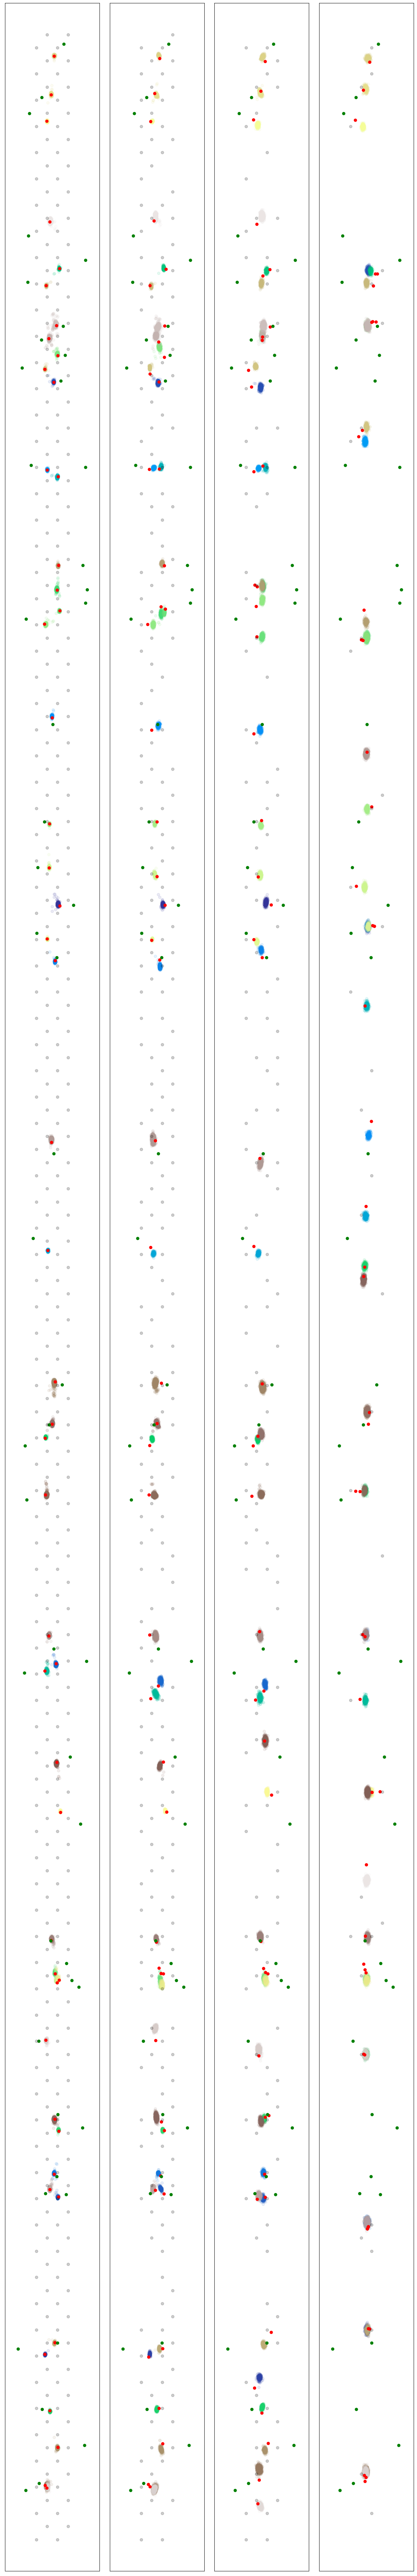

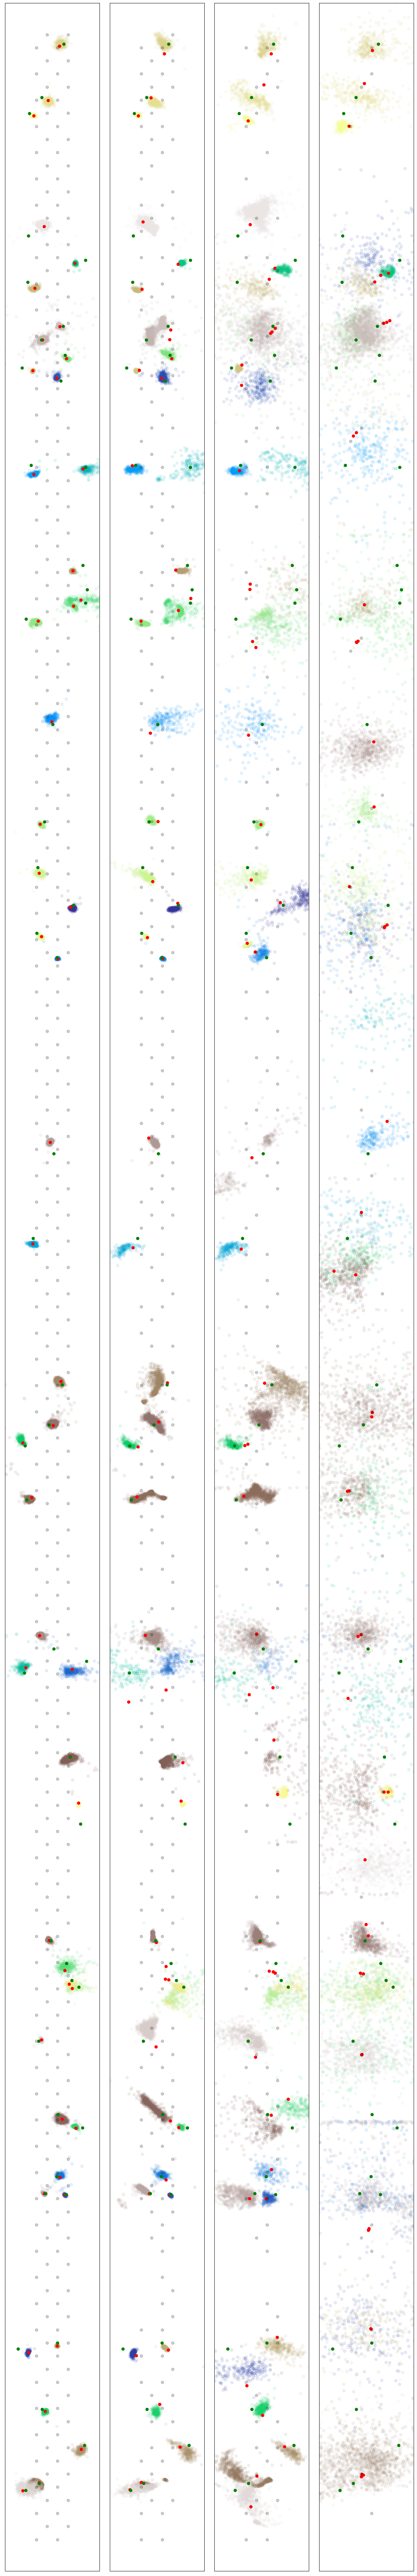

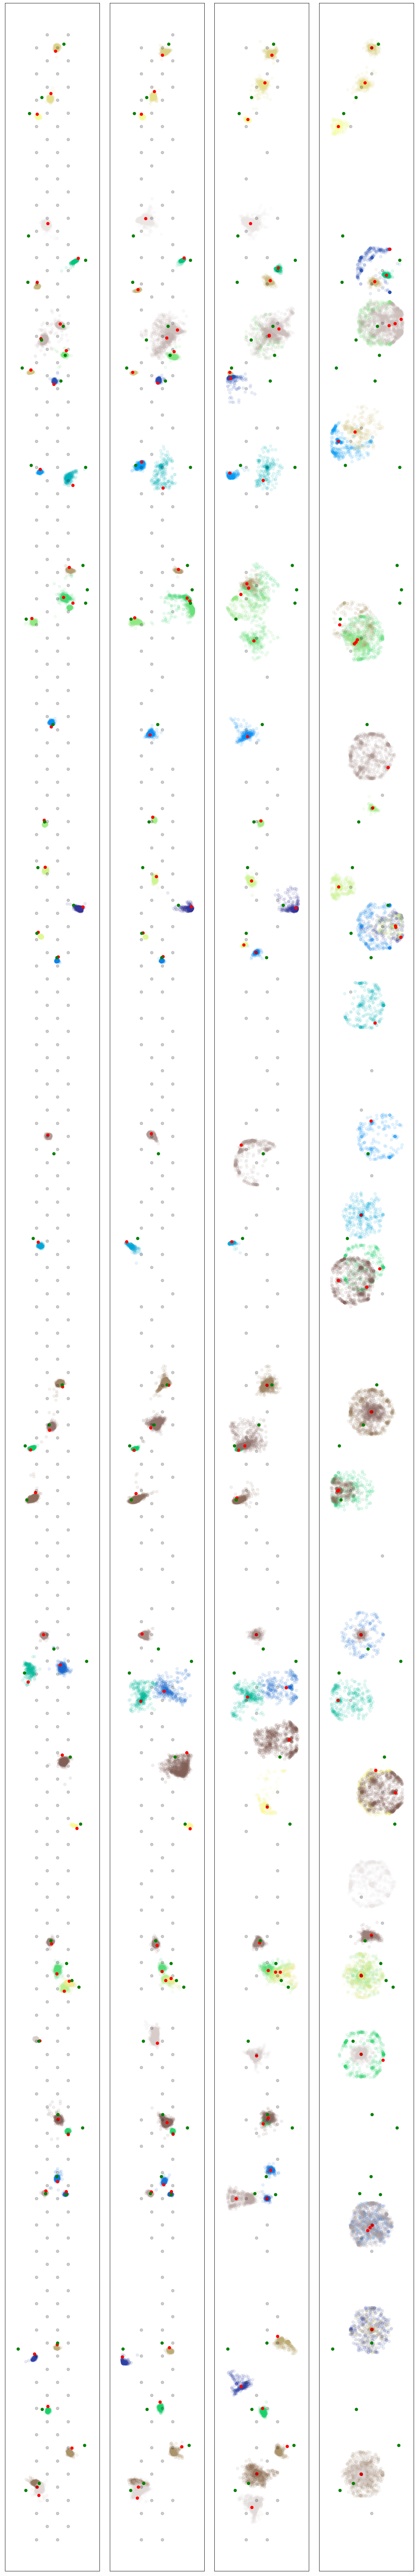

In [20]:
fig_days_2 = ['D0', 'D8', 'D16', 'D24']

for method in methods:

    range_x = electrode_loc[:, 0].max() - electrode_loc[:, 0].min()
    range_y = electrode_loc[:, 1].max() - electrode_loc[:, 1].min()
    range_A = min(range_x, range_y)

    # Create a single row with all days
    col_num = len(fig_days_2)
    fig, axs = plt.subplots(1, col_num, figsize=(4*col_num, 100))  
    plt.subplots_adjust(wspace=0.05)

    for we_i, we in enumerate(wes_gt):
        
        if days[we_i] in fig_days_2:

            loc_est_unit = loc_est_units[method][we_i]
            loc_est_spike = loc_est_spikes[method][days[we_i]]
            
            dead_electrodes = dead_indices[we_i]
            live_electrodes = np.delete(np.arange(electrode_loc.shape[0]), dead_electrodes)

            # Create plot - now using only column index
            col_gt = np.where(np.array(fig_days_2) == days[we_i])[0][0]

            for unit_idx, unit_id in enumerate(we.unit_ids):
                unit_loc_est_temp = loc_est_spike[0][unit_id]
                unit_loc_est_temp = np.array(unit_loc_est_temp.tolist())
                axs[col_gt].scatter(unit_loc_est_temp[:, 0], unit_loc_est_temp[:, 1], color=plt.get_cmap('terrain')(unit_idx*5), alpha=0.1, label='Estimated Spikes', rasterized=True)

            axs[col_gt].scatter(loc_est_unit[:, 0], loc_est_unit[:, 1], color='red', label='Estimated Templates')
            axs[col_gt].scatter(unit_loc_true[:, 1], unit_loc_true[:, 2], color='green', label='True Neurons')
            axs[col_gt].scatter(electrode_loc[live_electrodes, 0], electrode_loc[live_electrodes, 1], color=[0, 0, 0], alpha=0.2 , label='Electrodes')
            axs[col_gt].set_xlim([electrode_loc[:, 0].min() - range_A*1.0, electrode_loc[:, 0].max() + range_A*1.0])
            axs[col_gt].set_ylim([electrode_loc[:, 1].min() - range_A*1.0, electrode_loc[:, 1].max() + range_A*1.0])
            axs[col_gt].get_xaxis().set_visible(False)
            axs[col_gt].get_yaxis().set_visible(False)
            axs[col_gt].set_aspect('equal')
    
    fig.savefig(f'{output_mearec}/3C_{method}.svg', format='svg', bbox_inches='tight', dpi=100)

In [21]:
import importlib
import src

importlib.reload(src.util_eval)
from src.util_eval import *